In [1]:
import torch.nn as nn
import torch
import rawpy
import numpy as np
from torch.utils.data import DataLoader
from utils.datasets import LabeledDataset

import torchvision.transforms as transforms

import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import FID, InceptionScore, RunningAverage

from torch.profiler import profile, record_function, ProfilerActivity

from torchinfo import summary

In [2]:
root_dir = "dataset"
sony_csv_files = ["dataset/Sony_train_list.txt"]
fuji_csv_files =  ["dataset/Fuji_train_list.txt"]

batch_size = 4
input_size = 512

pre_crop_transform = transforms.Compose([
    transforms.ToTensor()
])

sony_dataset = LabeledDataset(root_dir, *sony_csv_files, transform=pre_crop_transform)
sony_dataloader = idist.auto_dataloader(sony_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True, prefetch_factor=1)
print(sony_dataset[0][0].shape)
print(sony_dataset[0][1].shape)

2023-06-10 21:37:55,837 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<utils.datasets.Labe': 
	{'batch_size': 4, 'num_workers': 8, 'shuffle': True, 'drop_last': True, 'prefetch_factor': 1, 'pin_memory': True}


torch.Size([1, 2848, 4256])
torch.Size([3, 2848, 4256])


In [3]:
sony_dataset.prime_buffer()

In [4]:
# from unet.unet_model import UNet
from torch import optim 
from ignite.handlers.param_scheduler import LRScheduler

class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channel, out_channel, kernel_size=kernel, stride=stride, padding=padding)
        self.lrelu1_1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv1_2 = nn.Conv2d(out_channel, out_channel, kernel_size=kernel, stride=stride,  padding=padding)
        self.lrelu1_2 = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.lrelu1_1(x)
        x = self.conv1_2(x)
        x = self.lrelu1_2(x)
        return x
    
class UpConcatBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UpConcatBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channel, in_channel // 2, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channel, out_channel)

    def forward(self, x1, x2):
        x1 = self.deconv(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv_block(x)

class UNet(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(UNet, self).__init__()
        
        self.down1 = ConvBlock(in_feat, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = ConvBlock(128, 256)
        self.pool4 = nn.MaxPool2d(2)
        self.down5 = ConvBlock(256, 512)

        self.up5 = UpConcatBlock(512, 256)
        self.up4 = UpConcatBlock(256, 128)
        self.up3 = UpConcatBlock(128, 64)
        self.up2 = UpConcatBlock(64, 32)

        self.conv10 = nn.Conv2d(32, out_feat, 1)

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(self.pool1(down1))
        down3 = self.down3(self.pool2(down2))
        down4 = self.down4(self.pool3(down3))
        down5 = self.down5(self.pool4(down4))

        up = self.up5(down5, down4)
        up = self.up4(up, down3)
        up = self.up3(up, down2)
        up = self.up2(up, down1)

        out = self.conv10(up)
        out = torch.nn.functional.pixel_shuffle(out, 2)
        return out
    
class UNet_D(nn.Module):
    def __init__(self, in_feat):
        super(UNet_D, self).__init__()
        
        self.down1 = ConvBlock(in_feat, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = ConvBlock(128, 256)
        self.pool4 = nn.MaxPool2d(2)
        self.down5 = ConvBlock(256, 512)
        self.pool5 = nn.MaxPool2d(2)
        self.down6 = ConvBlock(512, 1024)
        self.pool6 = nn.MaxPool2d(2)
        self.down7 = ConvBlock(1024, 2048)
        self.pool7 = nn.MaxPool2d(2)
        self.down8 = ConvBlock(2048, 4096)

        self.fc1 = nn.Linear(4096*8*8, 1)

        self.up8 = UpConcatBlock(4096, 2048)
        self.up7 = UpConcatBlock(2048, 1024)
        self.up6 = UpConcatBlock(1024, 512)
        self.up5 = UpConcatBlock(512, 256)
        self.up4 = UpConcatBlock(256, 128)
        self.up3 = UpConcatBlock(128, 64)
        self.up2 = UpConcatBlock(64, 32)

        self.conv10 = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(self.pool1(down1))
        down3 = self.down3(self.pool2(down2))
        down4 = self.down4(self.pool3(down3))
        down5 = self.down5(self.pool4(down4))
        down6 = self.down6(self.pool5(down5))
        down7 = self.down7(self.pool6(down6))
        down8 = self.down8(self.pool7(down7))

        down8_ = torch.flatten(down8, 1)
        real_fake = self.fc1(down8_)

        up = self.up8(down8, down7)
        up = self.up7(up, down6)
        up = self.up6(up, down5)
        up = self.up5(up, down4)
        up = self.up4(up, down3)
        up = self.up3(up, down2)
        up = self.up2(up, down1)

        out = self.conv10(up)
        return real_fake, out

In [5]:
netG = idist.auto_model(UNet(4, 12))
netD = idist.auto_model(UNet_D(3))
optimizerG = idist.auto_optim(optim.Adam(netG.parameters(), lr=1e-5, betas=(0.5, 0.999)))
optimizerD = idist.auto_optim(optim.Adam(netD.parameters(), lr=2e-5, betas=(0.5, 0.999)))
loss = nn.L1Loss()
criterion = nn.BCEWithLogitsLoss()
# lr_scheduler = LRScheduler(optim.lr_scheduler.StepLR(optimizerG, step_size=5, gamma=0.8))

2023-06-10 21:39:08,824 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model
2023-06-10 21:39:11,416 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


In [6]:
input_data = torch.randn(batch_size, 4, input_size, input_size)
summary(netG, input_data = input_data)
del input_data

In [7]:
input_data = torch.randn(batch_size, 3, input_size*2, input_size*2)
summary(netD, input_data = input_data)
del input_data

In [8]:
def random_crop(image_short, image_long, size):
    H = image_short.shape[2]
    W = image_short.shape[3]
    ps = size
    xx = np.random.randint(0, W - ps)
    yy = np.random.randint(0, H - ps)
    image_short = image_short[:,:,yy:yy + ps, xx:xx + ps]
    image_long = image_long[:,:,yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2]
    return image_short, image_long

def pack_sony_raw(batch, device=None):
    if not device:
        device = idist.device()
    batch = torch.maximum(batch - 512, torch.Tensor([0]).to(device=device)) / (16383 - 512)
    H = batch.shape[2]
    W = batch.shape[3]

    out = torch.cat((batch[:,:, 0:H:2, 0:W:2], 
                     batch[:,:, 0:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 0:W:2]), dim=1)
    return out

In [9]:
real_label = 1
fake_label = 0

def training_step(engine, batch):
    netG.train()
    netD.train()

    short, long, ratio, cam_model, exposure_ratio, _, _, _ = batch

    short = short.to(idist.device())
    long = long.to(idist.device())

    short = pack_sony_raw(short)

    long = long / 65535.0
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
    short, long = random_crop(short, long, input_size)

    # Train Discriminator with ground truth data
    netD.zero_grad()
    b_size = long.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())

    D_real_enc_out, D_real_dec_out = netD(long)
    D_real_enc_out = D_real_enc_out.view(-1)
    errD_real_enc = criterion(D_real_enc_out, label)
    errD_real_dec = criterion(D_real_dec_out, label.view(-1, 1, 1, 1).expand_as(D_real_dec_out))
    errD_real = errD_real_enc + errD_real_dec
    errD_real.backward()

    # Train with all-fake batch
    fake = netG(short)
    label.fill_(fake_label)

    D_fake_enc_out, D_fake_dec_out = netD(fake.detach())
    D_fake_enc_out = D_fake_enc_out.view(-1)
    errD_fake_enc = criterion(D_fake_enc_out, label)
    errD_fake_dec = criterion(D_fake_dec_out, label.view(-1, 1, 1, 1).expand_as(D_fake_dec_out))
    errD_fake = errD_fake_enc + errD_fake_dec
    errD_fake.backward()

    errD = errD_real + errD_fake
    optimizerD.step()

    # Train G
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost

    G_D_enc_out, G_D_dec_out = netD(fake)
    
    errG_l1 = loss(fake, long)
    errG_dec = criterion(G_D_dec_out, label.view(-1, 1, 1, 1).expand_as(G_D_dec_out))
    errG = 0.99*errG_l1 + 0.01*errG_dec
    errG.backward()

    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_real_enc": errD_real_enc.mean().item(),
        "D_real_dec": errD_real_dec.mean().item(),
        "D_fake_enc": errD_fake_enc.mean().item(),
        "D_fake_dec": errD_fake_dec.mean().item(),
        "D_G_L1": errG_l1.item(),
        "D_G_dec": errG_dec.mean().item(),
    }

In [10]:
trainer = Engine(training_step)
# trainer.add_event_handler(Events.EPOCH_STARTED, lr_scheduler)
losses_key = ["Loss_G","Loss_D","D_real_enc","D_real_dec","D_fake_enc","D_fake_dec","D_G_L1","D_G_dec"]
losses = {}
for k in losses_key:
    losses[k] = []

RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, "Loss_G")
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, "Loss_D")  
RunningAverage(output_transform=lambda x: x["D_real_enc"]).attach(trainer, "D_real_enc")  
RunningAverage(output_transform=lambda x: x["D_real_dec"]).attach(trainer, "D_real_dec")  
RunningAverage(output_transform=lambda x: x["D_fake_enc"]).attach(trainer, "D_fake_enc")  
RunningAverage(output_transform=lambda x: x["D_fake_dec"]).attach(trainer, "D_fake_dec")  
RunningAverage(output_transform=lambda x: x["D_G_L1"]).attach(trainer, "D_G_L1")  
RunningAverage(output_transform=lambda x: x["D_G_dec"]).attach(trainer, "D_G_dec")  
ProgressBar().attach(trainer, metric_names=["Loss_G","Loss_D","D_real_enc","D_real_dec","D_fake_enc","D_fake_dec","D_G_L1","D_G_dec"])

@trainer.on(Events.EPOCH_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    print(o["D_G_L1"])
    for k in losses_key:
        losses[k].append(o[k])

best_l1 = 9999
@trainer.on(Events.EPOCH_COMPLETED)
def save_checkpoint(engine):
    global best_l1
    if engine.state.output["D_G_L1"] < best_l1:
        best_l1 = engine.state.output["D_G_L1"]

    torch.save({
        'epoch': engine.state.epoch,
        'model_state_dict': netG.state_dict(),
        'optimizer_state_dict': optimizerG.state_dict(),
        'loss': criterion,
        'l1loss': loss,
        'modelD_state_dict': netD.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        }, 'model_best.pt')

/home/pikachu/.local/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [11]:
num_epoch = 100
def training(*args):
    trainer.run(sony_dataloader, max_epochs=num_epoch)

with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

2023-06-10 21:39:18,114 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2023-06-10 21:39:18,114 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7fcf17f90af0>' in 1 processes


0.1474871039390564


0.1290379762649536


0.08463647216558456


0.10403493046760559


0.0677143856883049


0.07833059132099152


0.07802726328372955


0.07586946338415146


0.03862138092517853


0.05459936708211899


0.0817616730928421


0.05557216331362724


0.04855310916900635


0.07831006497144699


0.06477276235818863


0.05404284596443176


0.0552414208650589


0.0793076679110527


0.05899692699313164


0.06430389732122421


0.04589614272117615


0.04985903948545456


0.10269394516944885


0.05238933116197586


0.07614552974700928


0.10413738340139389


0.06327112019062042


0.046711742877960205


0.05233709514141083


0.09688391536474228


0.0488491952419281


0.04260588809847832


0.08618736267089844


0.03810599446296692


0.08109430968761444


0.06055832654237747


0.049529992043972015


0.05475611984729767


0.10897831618785858


0.06435783952474594


0.09165923297405243


0.05327858775854111


0.09194176644086838


0.05165432021021843


0.04927143454551697


0.05600135773420334


0.1212926059961319


0.06219976395368576


0.06674565374851227


0.054918088018894196


0.04705408960580826


0.05998852476477623


0.0561138316988945


Epoch [54/100]: [228/466]  49%|████▉     , Loss_G=0.0866, Loss_D=0.824, D_real_enc=0.189, D_real_dec=0.257, D_fake_enc=0.16, D_fake_dec=0.218, D_G_L1=0.0596, D_G_dec=2.76 [12:21<13:13]  Engine run is terminating due to exception: 
2023-06-11 20:28:58,361 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


KeyboardInterrupt: 

In [12]:
torch.save({
            'epoch': num_epoch,
            'model_state_dict': netG.state_dict(),
            'optimizer_state_dict': optimizerG.state_dict(),
            'loss': criterion,
            'modelD_state_dict': netD.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            }, 'model_seed_{}.pt'.format(torch.random.initial_seed()))

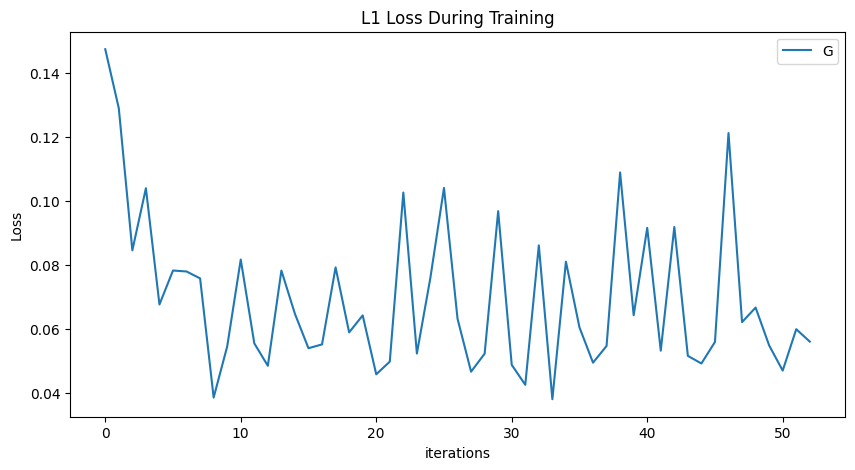

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("L1 Loss During Training")
plt.plot(losses['D_G_L1'],label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

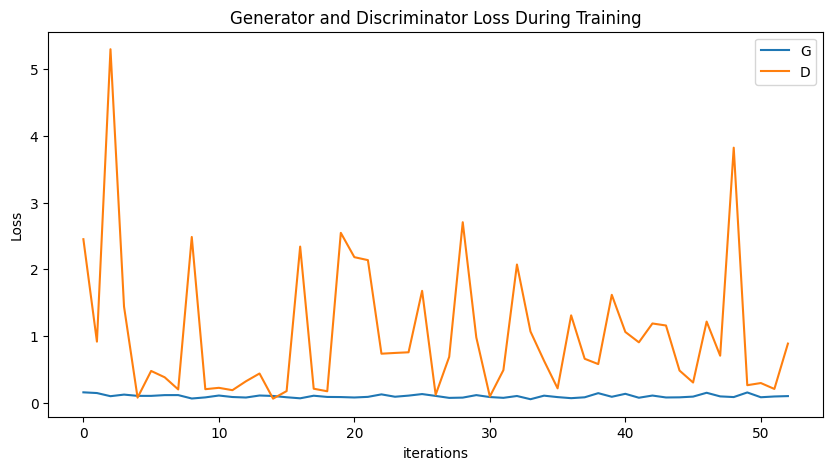

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses['Loss_G'],label="G")
plt.plot(losses['Loss_D'],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

In [15]:
import cv2

# Load best model
checkpoint = torch.load('model_best.pt')
# checkpoint = torch.load('model_seed_{}.pt'.format(torch.random.initial_seed()))
best_model = idist.auto_model(UNet(4, 12))

best_model.load_state_dict(checkpoint['model_state_dict'])

root_dir = "dataset"
sony_test_csv_files = ["dataset/Sony_test_list.txt"]

sony_test_dataset = LabeledDataset(root_dir, *sony_test_csv_files, transform=transforms.Compose([
    transforms.ToTensor()
]))
sony_test_dataloader = DataLoader(sony_test_dataset, batch_size=1, num_workers=1)


2023-06-11 20:30:27,596 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


tensor(9.9451e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0.0249, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(250., device='cuda:0')
0.17004311 0.12869063 0.0 1.0
0.13495679 0.094539054 0.0 0.81612563
0.10160973 0.069560565 0.0 1.0
0.1745267 0.13415731 0.0 1.0
0.15320197 0.12263676 0.0 1.0
0.11769672 0.09105058 0.0 1.0


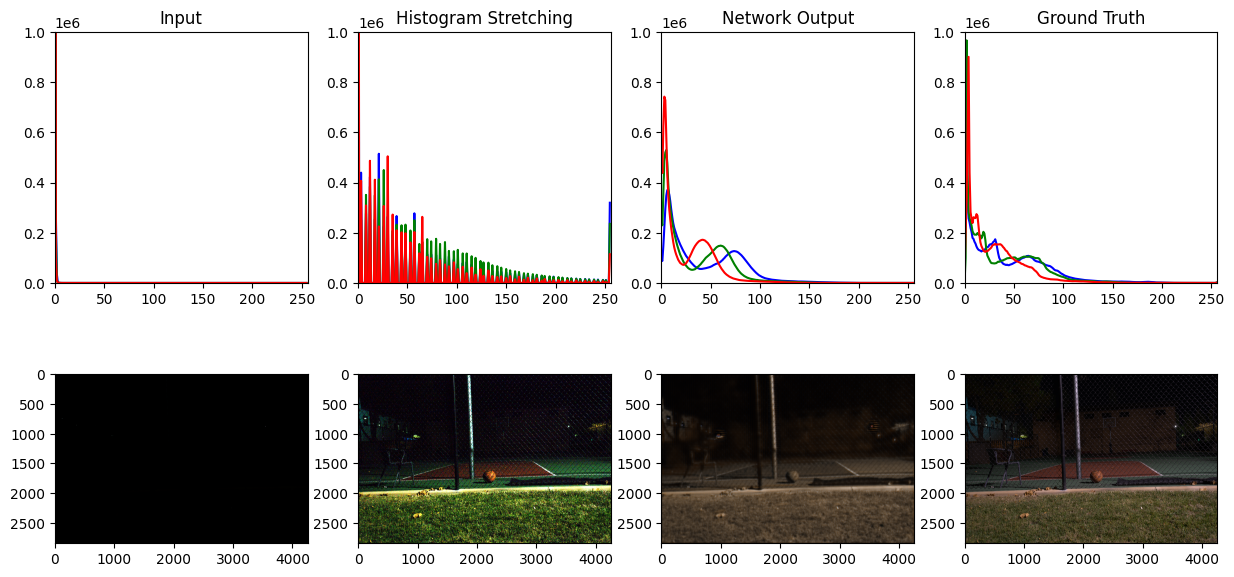

tensor(0.0003, device='cuda:0') tensor(0.0001, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0.0300, device='cuda:0') tensor(0.0126, device='cuda:0') tensor(0., device='cuda:0') tensor(100., device='cuda:0')
0.19288933 0.16978207 0.0 0.8218533
0.15271118 0.1284803 0.0 0.78825366
0.11367712 0.094946995 0.0 0.787447
0.1745267 0.13415731 0.0 1.0
0.15320197 0.12263676 0.0 1.0
0.11769672 0.09105058 0.0 1.0


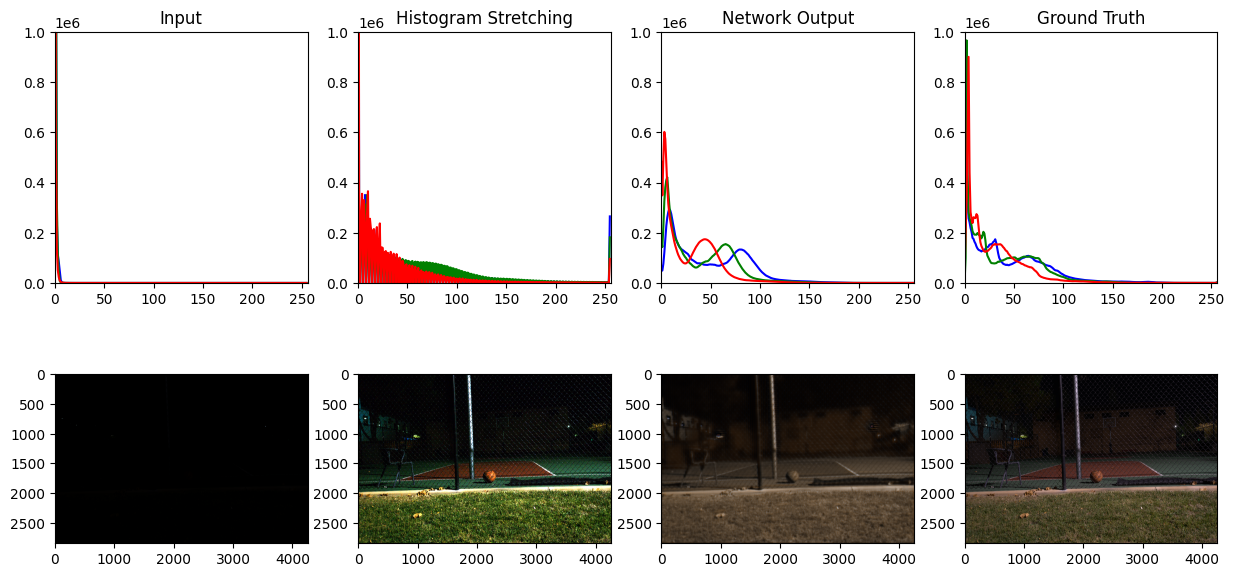

tensor(0.0001, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0129, device='cuda:0')
tensor(0.0317, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(3.2134, device='cuda:0')
0.16873354 0.16764599 0.0 0.7791499
0.12770844 0.119662754 0.0 0.75772506
0.09493881 0.08184545 0.0 0.7784713
0.16390072 0.16130312 0.0 1.0
0.13471788 0.12680247 0.0 1.0
0.13667648 0.1257496 0.0 1.0


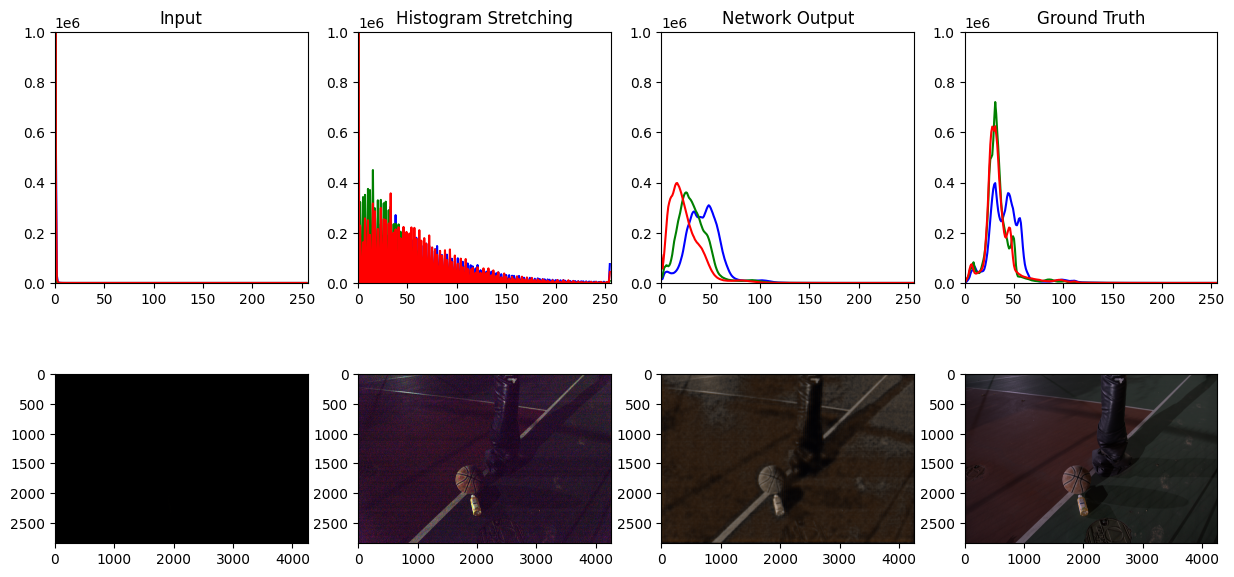

tensor(8.3668e-05, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.1387, device='cuda:0')
tensor(0.0209, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(34.6702, device='cuda:0')
0.15029761 0.13870475 0.0 0.99428064
0.115363754 0.10120769 0.0 0.9595446
0.08477801 0.068432465 0.0 1.0
0.1526067 0.1371023 0.0 1.0
0.13751055 0.12762646 0.0 1.0
0.11115194 0.11282521 0.0 1.0


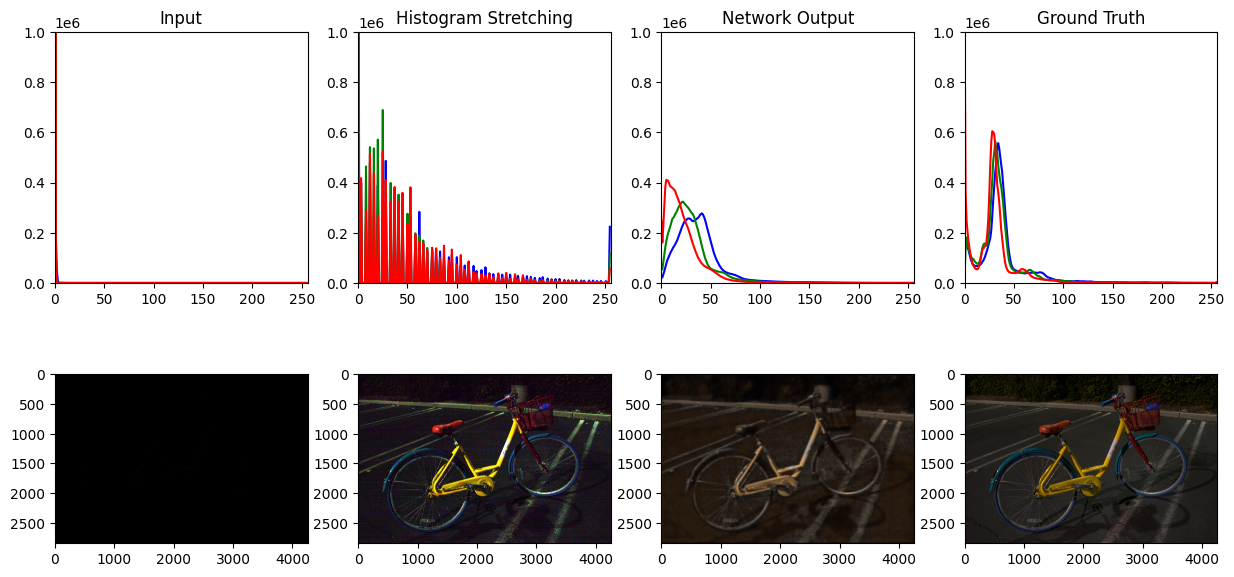

tensor(9.3496e-05, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0594, device='cuda:0')
tensor(0.0234, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(14.8384, device='cuda:0')
0.15499607 0.13474065 0.0 1.0
0.12087137 0.097810425 0.0 0.90767664
0.09060661 0.068005316 0.0 0.87370497
0.17585072 0.16221866 0.0 1.0
0.12842868 0.10785077 0.0 1.0
0.07044467 0.047241934 0.0 1.0


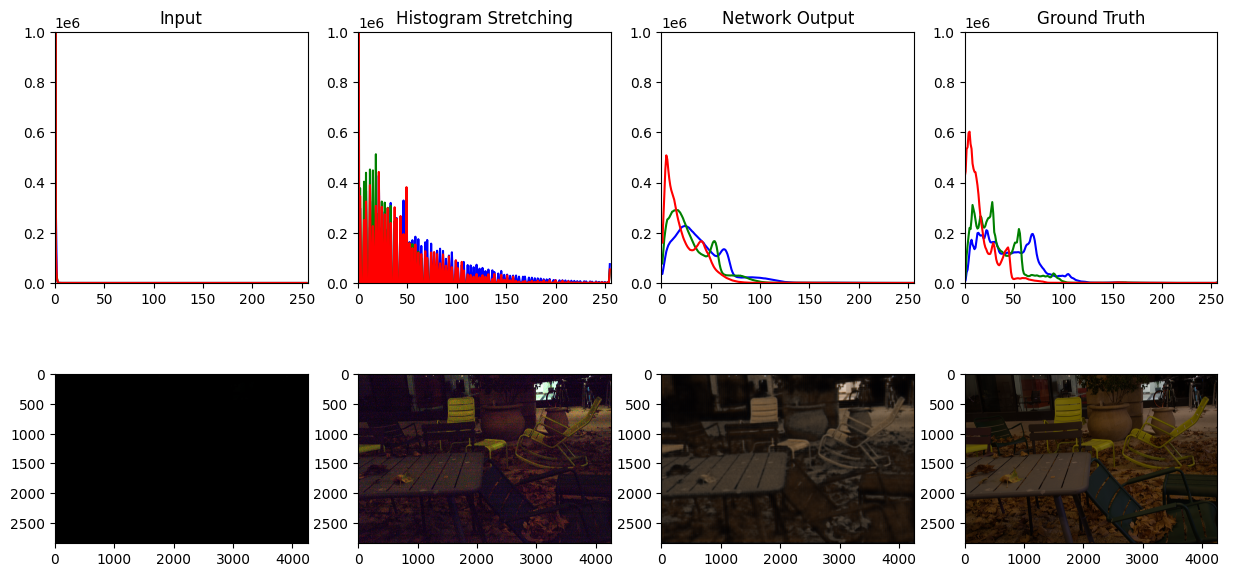

tensor(0.0002, device='cuda:0') tensor(0.0001, device='cuda:0') tensor(0., device='cuda:0') tensor(0.1466, device='cuda:0')
tensor(0.0224, device='cuda:0') tensor(0.0126, device='cuda:0') tensor(0., device='cuda:0') tensor(14.6620, device='cuda:0')
0.17033271 0.14958052 0.0 0.9673609
0.1341044 0.116836876 0.0 0.8860409
0.098755285 0.08741433 0.0 0.85251015
0.17585072 0.16221866 0.0 1.0
0.12842868 0.10785077 0.0 1.0
0.07044467 0.047241934 0.0 1.0


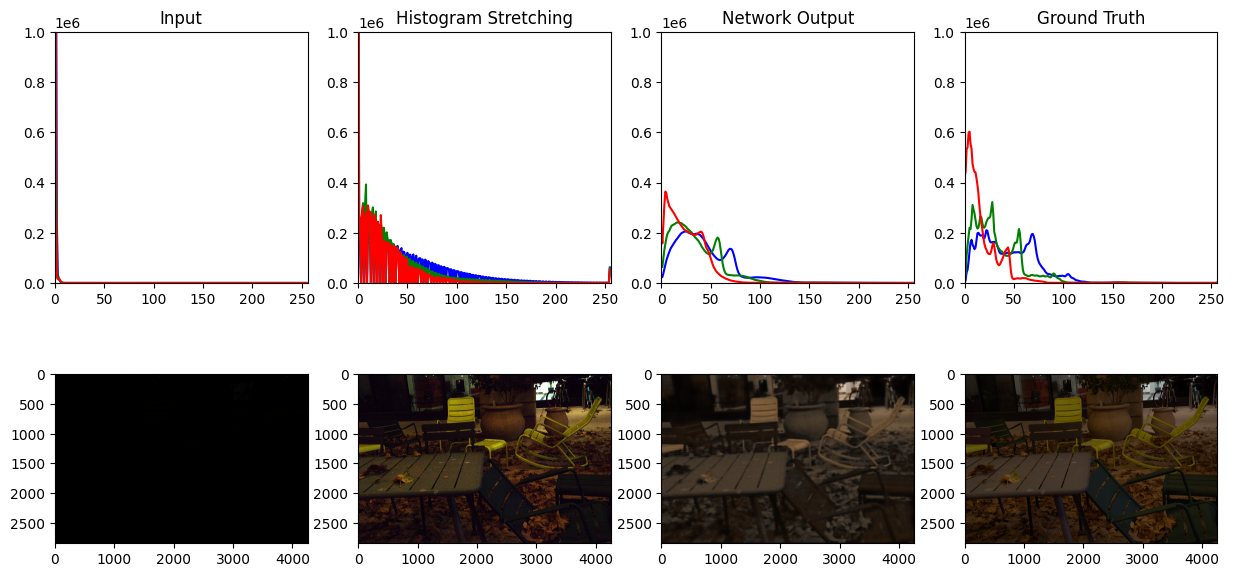

tensor(0.0011, device='cuda:0') tensor(0.0008, device='cuda:0') tensor(0., device='cuda:0') tensor(0.7309, device='cuda:0')
tensor(0.1149, device='cuda:0') tensor(0.0756, device='cuda:0') tensor(0., device='cuda:0') tensor(73.0893, device='cuda:0')
0.44008598 0.44868064 0.0 0.9904128
0.36301765 0.36505038 0.0 0.86583906
0.28293937 0.2725166 0.0 0.78314614
0.45840585 0.45607692 0.0 1.0
0.36945933 0.37097734 0.004806592 1.0
0.22926527 0.18481727 0.0 1.0


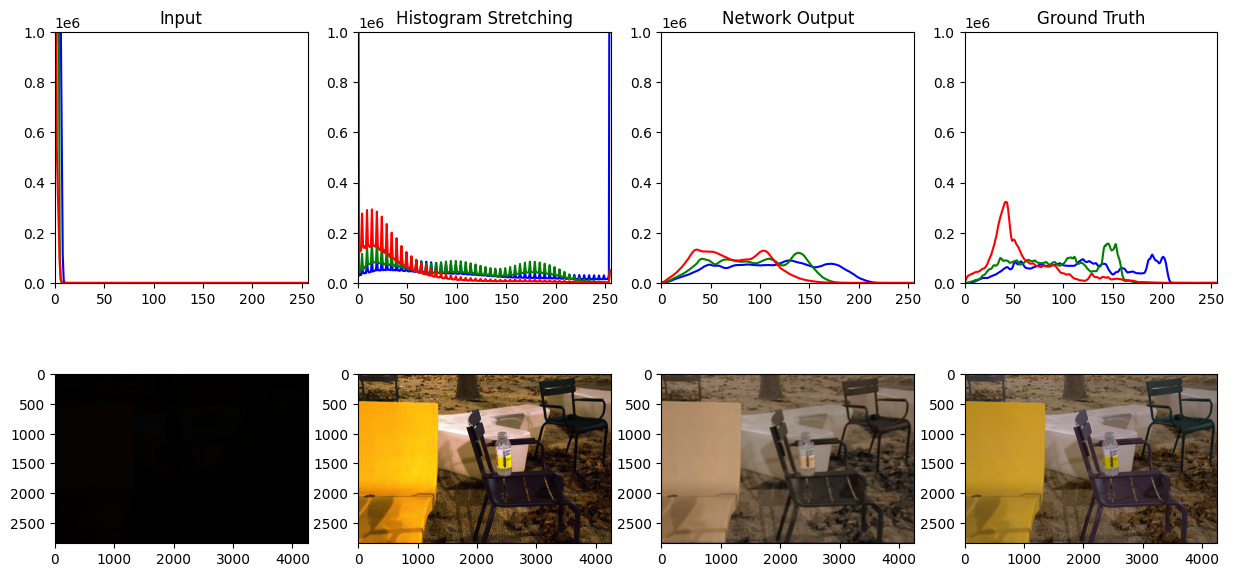

In [17]:
import matplotlib.pyplot as plt

with torch.no_grad():
    best_model.eval()
    list_samp = [1, 13, 27, 39, 51, 61, 73]
    o = 0
    for batch in sony_test_dataloader:
    # batch = next(iter(sony_test_dataloader))
        short, long, ratio, cam_model, exposure_ratio, _, _, short_raw = batch
        o += 1
        if o > list_samp[-1]:
            break
        if o not in list_samp:
            continue
        short_ = short
        short = short.to(idist.device())
        long = long.to(idist.device())

        short = pack_sony_raw(short)
        print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
        long = long / 65535.0
        short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
        print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
        
        
        output = best_model(short)
        # output = torch.nn.functional.pixel_shuffle(output, 2)

        output = output[0, :, :, :].to('cpu').numpy()
        output = np.minimum(np.maximum(output, 0), 1)
        gt_full = long[0, :, :, :].to('cpu').numpy()
        raw_input = short_raw[0, :, :, :].to('cpu').numpy() / 65535.0
        scale_full = np.float32(short_raw[0, :, :, :].to('cpu').numpy() / 65535.0)
        scale_full = scale_full * np.mean(gt_full) / np.mean(scale_full) 

        print(np.mean(output[0]), np.median(output[0]), np.min(output[0]), np.max(output[0]))
        print(np.mean(output[1]), np.median(output[1]), np.min(output[1]), np.max(output[1]))
        print(np.mean(output[2]), np.median(output[2]), np.min(output[2]), np.max(output[2]))
        print(np.mean(gt_full[0]), np.median(gt_full[0]), np.min(gt_full[0]), np.max(gt_full[0]))
        print(np.mean(gt_full[1]), np.median(gt_full[1]), np.min(gt_full[1]), np.max(gt_full[1]))
        print(np.mean(gt_full[2]), np.median(gt_full[2]), np.min(gt_full[2]), np.max(gt_full[2]))

        output = np.minimum(np.transpose(output, (1,2,0)) * 255, 255).astype(np.uint8)
        # output = (output-np.min(output))/(np.max(output)-np.min(output))
        gt_full = np.minimum(np.transpose(gt_full, (1,2,0)) * 255, 255).astype(np.uint8)
        raw_input = np.minimum(raw_input * 255, 255).astype(np.uint8)
        scale_full = np.minimum(scale_full * 255, 255).astype(np.uint8)

        color = ('b','g','r')
        plt.figure(figsize=(15,15))
        ax = plt.subplot(4,4,1)
        ax.set_title("Input")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([raw_input],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,5)
        plt.imshow(raw_input)

        ax = plt.subplot(4,4,2)
        ax.set_title("Histogram Stretching")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([scale_full],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,6)
        plt.imshow(scale_full)

        ax = plt.subplot(4,4,3)
        ax.set_title("Network Output")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([output],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,7)
        plt.imshow(output)

        ax = plt.subplot(4,4,4)
        ax.set_title("Ground Truth")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([gt_full],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,8)
        plt.imshow(gt_full)
        plt.show()

In [18]:
print(losses)

{'Loss_G': [0.15469130873680115, 0.14400961995124817, 0.09665347635746002, 0.1206013411283493, 0.10163536667823792, 0.10147614777088165, 0.1128363236784935, 0.11316803097724915, 0.061947278678417206, 0.07880860567092896, 0.10675453394651413, 0.0843648761510849, 0.0768539234995842, 0.1069614514708519, 0.10012035071849823, 0.08075195550918579, 0.0650234967470169, 0.10378088057041168, 0.08551020175218582, 0.0836482048034668, 0.07732808589935303, 0.08664458245038986, 0.12396612763404846, 0.0885649174451828, 0.10532450675964355, 0.12866920232772827, 0.10076602548360825, 0.07143981754779816, 0.07542076706886292, 0.1128692775964737, 0.0838117003440857, 0.07206512987613678, 0.0997048169374466, 0.051266949623823166, 0.10469728708267212, 0.08303049206733704, 0.06699834018945694, 0.08013750612735748, 0.14225757122039795, 0.08794192969799042, 0.13236576318740845, 0.07359285652637482, 0.10640109330415726, 0.07757194340229034, 0.0796050876379013, 0.09043058753013611, 0.14797288179397583, 0.093631610